In [1]:
!pip install tpot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=1b09d9af7182ada04b426501536359a5506b9216aa387163dad8ccbea6014c58
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy import stats


import pandas as pd
%matplotlib inline

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv', index_col=0)

df.head()
df.index.name = 'date'
df.index = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.drop(['year', 'month', 'day', 'hour'], axis=1, inplace=True)
df = df[24:]


In [4]:
d = df['pm2.5']
s_fwd = d.interpolate(method="polynomial", order=3, limit_direction = 'forward')
s_bkd = d.interpolate(method="polynomial", order=3, limit_direction = 'backward')
print(s_fwd.count())
print(s_bkd.count())
type(s_bkd)
tmp_df = pd.DataFrame()
tmp_df['fwd'] = s_fwd
tmp_df['bkd'] = s_bkd
tmp_df['mean']= tmp_df.mean(axis = 1)
tmp_df['mean'][tmp_df['mean']<0] = 0
df['pm2.5'] = tmp_df['mean']

43800
43800


In [5]:
df.drop(['cbwd'],axis=1, inplace=True)

In [6]:
df = df.reset_index(drop=True)

In [7]:
def preprocess(df):
  df2 = df.copy()
  num_lags = 8 # number of lags and window lenghts for mean aggregation
  delay = 1 # predict target one step ahead
  for column in df2:
      for lag in range(1,num_lags+1):
          df2[column + '_lag' + str(lag)] = df2[column].shift(lag*-1-(delay-1))
          if column != 'wnd_dir':
              df2[column + '_avg_window_length' + str(lag+1)] = df2[column].shift(-1-(delay-1)).rolling(window=lag+1,center=False).mean().shift(1-(lag+1))

  df2.dropna(inplace=True)

  mask = (df2.columns.str.contains('pm2.5') | df2.columns.str.contains('lag') | df2.columns.str.contains('window'))
  df_processed = df2[df2.columns[mask]]
  return df_processed



In [8]:
preproc = True
if preproc:
  df_processed = preprocess(df)
else:
  df_processed = df

<ipython-input-7-ce1548a419b7>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[column + '_lag' + str(lag)] = df2[column].shift(lag*-1-(delay-1))
<ipython-input-7-ce1548a419b7>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[column + '_avg_window_length' + str(lag+1)] = df2[column].shift(-1-(delay-1)).rolling(window=lag+1,center=False).mean().shift(1-(lag+1))
<ipython-input-7-ce1548a419b7>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

In [9]:
df_processed.shape

(43791, 113)

In [10]:
df_processed.head()

,pm2.5,pm2.5_lag1,pm2.5_avg_window_length2,pm2.5_lag2,pm2.5_avg_window_length3,pm2.5_lag3,pm2.5_avg_window_length4,pm2.5_lag4,pm2.5_avg_window_length5,pm2.5_lag5,...,Ir_lag4,Ir_avg_window_length5,Ir_lag5,Ir_avg_window_length6,Ir_lag6,Ir_avg_window_length7,Ir_lag7,Ir_avg_window_length8,Ir_lag8,Ir_avg_window_length9
0,129.0,148.0,153.5,159.0,162.666667,181.0,156.50,138.0,147.0,109.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,148.0,159.0,170.0,181.0,159.333333,138.0,146.75,109.0,138.4,105.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,159.0,181.0,159.5,138.0,142.666667,109.0,133.25,105.0,131.4,124.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,181.0,138.0,123.5,109.0,117.333333,105.0,119.00,124.0,119.2,120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,138.0,109.0,107.0,105.0,112.666667,124.0,114.50,120.0,118.0,132.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_processed.reset_index(drop=True,inplace=True)
df_train = df_processed.loc[:int(df_processed.shape[0]*0.8),:]
df_test = df_processed.loc[int(df_processed.shape[0]*0.8):,:]

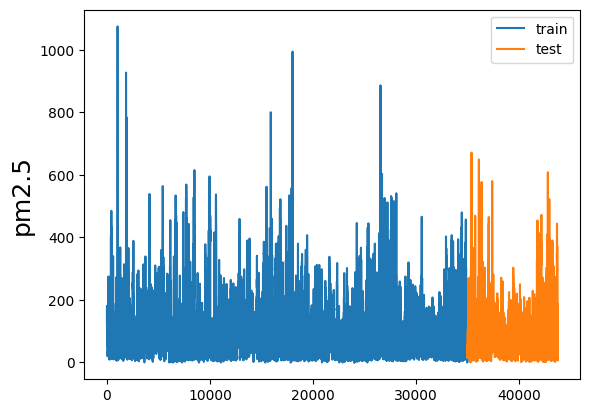

In [12]:
plt.plot(df_train.index,df_train['pm2.5'])
plt.plot(df_test.index,df_test['pm2.5'])
plt.ylabel('pm2.5',fontsize=18)
plt.legend(['train','test'])
plt.show()

In [13]:
train_class = df_train['pm2.5'].values
train_class

array([129., 148., 159., ...,  22.,  19.,  16.])

In [14]:
y = 'pm2.5'
X = df_train.loc[:, df_train.columns != 'pm2.5'].columns.tolist()

In [15]:
X_train = df_train[X]
Y_train = df_train[y]
X_test = df_test[X]
Y_test = df_test[y]


In [24]:
from tpot import TPOTRegressor
import time
start_time = time.time()

tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2)
tpot.fit(X_train, Y_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Best pipeline: LassoLarsCV(input_matrix, normalize=False)


TPOTRegressor(generations=5, population_size=20, verbosity=2)

In [17]:
end = time.time()


In [18]:
end-start_time

1890.8418452739716

In [19]:
print("TPOT cross-validation MSE")
print(tpot.score(X_test, Y_test))

TPOT cross-validation MSE
-461.8023110214398


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(


In [20]:
from sklearn.metrics import mean_squared_error
print('RMSE:')
print(np.sqrt(mean_squared_error(df_processed[y], tpot.predict(df_processed[X]))))

RMSE:
22.940266666984865


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(


In [21]:
print('RMSE:')
rmse = round(np.sqrt(mean_squared_error(Y_test, tpot.predict(X_test))),2)
rmse

RMSE:


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(


21.49

In [22]:
tpot.predict(df_processed[X])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(


array([141.31562883, 145.46331778, 190.47193224, ...,  13.39843713,
         8.06303512,   8.48616224])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'TPOT Output RMSE: 21.49')

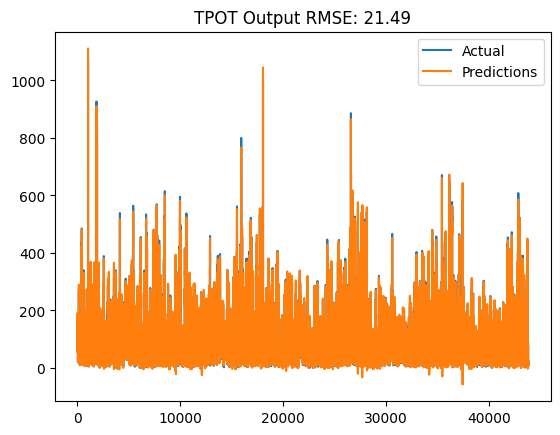

In [23]:
plt.plot(df_processed[y], label = 'Actual')
plt.plot(tpot.predict(df_processed[X]), label = 'Predictions')
plt.legend()
plt.title("TPOT Output RMSE: "+str(rmse) )